**Q1:** Below is the two-pass approach

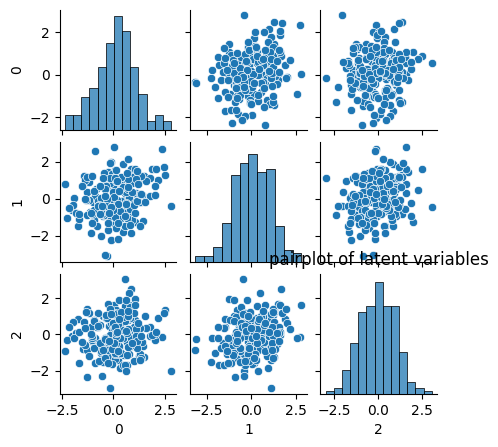

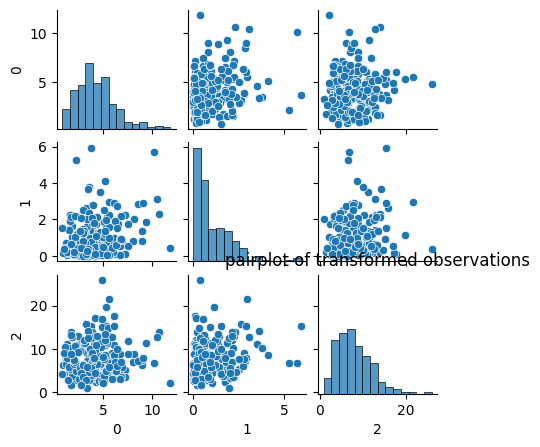

Output()

Output()

Output()

Output()

/usr/local/lib/python3.11/dist-packages/pytensor/compile/function/types.py:1037: RuntimeWarning: invalid value 
encountered in accumulate
  outputs = vm() if output_subset is None else vm(output_subset=output_subset)

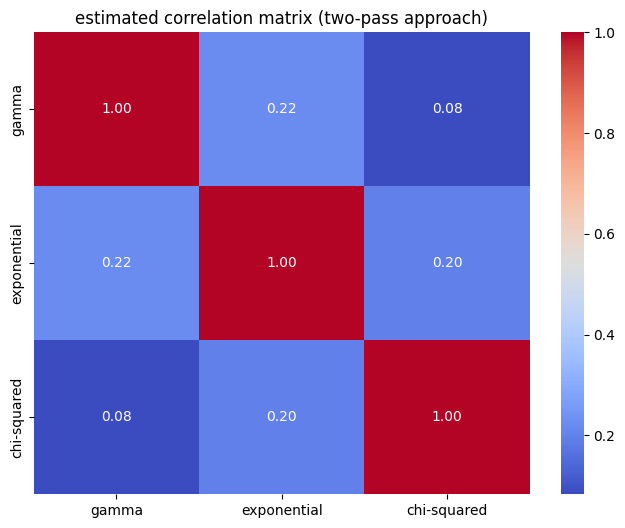

estimated gamma shape parameter: 4.2540
estimated exponential rate parameter: 0.9520
estimated chi-squared degrees of freedom: 7.9550
estimated correlation matrix: 
[[1.         0.22072341 0.08328997]
 [0.22072341 1.         0.19534516]
 [0.08328997 0.19534516 1.        ]]


In [ ]:
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
from scipy.stats import gamma, expon, chi2, norm
import seaborn as sns
import pandas as pd

# generate synthetic data with a custom correlation structure
def generate_data(n: int, p: int) -> tuple[np.ndarray, np.ndarray]:
    corr_matrix = np.eye(p) * 0.8 + np.ones((p, p)) * 0.2
    corr_matrix[0, -1] -= 0.1
    corr_matrix[-1, 0] -= 0.1
    x = np.random.multivariate_normal(np.zeros(p), corr_matrix, size=n)
    y = np.column_stack([
        gamma(a=4).ppf(norm.cdf(x[:, 0])),
        expon(scale=1).ppf(norm.cdf(x[:, 1])),
        chi2(df=8).ppf(norm.cdf(x[:, 2]))
    ])
    return x, y

# transform data to standard normal space
def transform_to_normal(data, dist):
    cdf_vals = dist.cdf(data)
    return norm.ppf(np.clip(cdf_vals, 1e-10, 1 - 1e-10))

# generate data
x_data, y_data = generate_data(n=200, p=3)

# visualize data
sns.pairplot(pd.DataFrame(x_data), height=1.5)
plt.title("pairplot of latent variables")
plt.show()

sns.pairplot(pd.DataFrame(y_data), height=1.5)
plt.title("pairplot of transformed observations")
plt.show()

# first pass: marginal estimation
with pm.Model() as gamma_model:
    alpha = pm.HalfNormal('alpha', sigma=12)
    y0 = pm.Gamma('y0', alpha=alpha, beta=1, observed=y_data[:, 0])
    trace_gamma = pm.sample(500, tune=300, target_accept=0.9)

alpha_mean = az.summary(trace_gamma, var_names=['alpha'])['mean'].values[0]

with pm.Model() as expo_model:
    beta = pm.HalfNormal('beta', sigma=12)
    y1 = pm.Exponential('y1', lam=beta, observed=y_data[:, 1])
    trace_expo = pm.sample(500, tune=300, target_accept=0.9)

beta_mean = az.summary(trace_expo, var_names=['beta'])['mean'].values[0]

with pm.Model() as chisq_model:
    nu = pm.HalfNormal('nu', sigma=12)
    y2 = pm.ChiSquared('y2', nu=nu, observed=y_data[:, 2])
    trace_chisq = pm.sample(500, tune=300, target_accept=0.9)

nu_mean = az.summary(trace_chisq, var_names=['nu'])['mean'].values[0]

# transform to latent normal space
z0 = transform_to_normal(y_data[:, 0], gamma(a=alpha_mean, scale=1))
z1 = transform_to_normal(y_data[:, 1], expon(scale=1 / beta_mean))
z2 = transform_to_normal(y_data[:, 2], chi2(df=nu_mean))
z_data = np.column_stack([z0, z1, z2])

# second pass: copula estimation
with pm.Model() as copula_model:
    chol, R, stds = pm.LKJCholeskyCov(
        'R', n=3, eta=2.5, sd_dist=pm.Exponential.dist(1.0), compute_corr=True
    )
    cov_matrix = pm.Deterministic('cov', chol @ chol.T)
    pm.MvNormal('latent', mu=np.zeros(3), chol=chol, observed=z_data)
    trace_copula = pm.sample(500, tune=300, target_accept=0.9)

# extract correlation matrix
corr_samples = np.mean(trace_copula.posterior['R'].values, axis=(0, 1))
estimated_corr = np.zeros((3, 3))
estimated_corr[np.tril_indices(3)] = corr_samples
estimated_corr = estimated_corr + estimated_corr.T - np.diag(np.diag(estimated_corr))
np.fill_diagonal(estimated_corr, 1)

# plot estimated correlation matrix
plt.figure(figsize=(8, 6))
plt.title("estimated correlation matrix (two-pass approach)")
sns.heatmap(estimated_corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.xticks([0.5, 1.5, 2.5], ['gamma', 'exponential', 'chi-squared'])
plt.yticks([0.5, 1.5, 2.5], ['gamma', 'exponential', 'chi-squared'])
plt.show()

print(f"estimated gamma shape parameter: {alpha_mean:.4f}")
print(f"estimated exponential rate parameter: {beta_mean:.4f}")
print(f"estimated chi-squared degrees of freedom: {nu_mean:.4f}")
print(f"estimated correlation matrix: \n{estimated_corr}")


**Q1A:** A copula is a function that captures the dependency structure between random variables, independent of their marginal distributions. It models multivariate distributions by decoupling the dependence structure from the individual marginals.

One-step v two-step approach:
In the one-step approach, marginal distributions and the copula are estimated simultaneously. This method is efficient but can struggle with complex dependencies. A Gaussian copula is typically used, where the marginals are transformed to a standard normal space, allowing the copula to capture correlations.

Two-Pass Approach:
The two-pass approach separates marginal estimation from copula estimation:

First Pass: Estimate each marginal independently using Bayesian methods. Transform the data to latent normal space using the fitted CDFs.

Second Pass: Fit a Gaussian copula to the transformed data, capturing the correlation independently of the marginals.

**Using Copulas for Multivariate GLMs:**
*   Choose appropriate marginal distributions for each variable.
*   Estimate each marginal distribution independently.
*   Combine the estimated marginals and copula to make joint predictions.
*   Use a Gaussian copula to model the dependence structure after transforming marginals.

**Q2**

Output()

/usr/local/lib/python3.11/dist-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
ERROR:pymc.stats.convergence:There were 143 divergences after tuning. Increase `target_accept` or reparameterize.


Output()

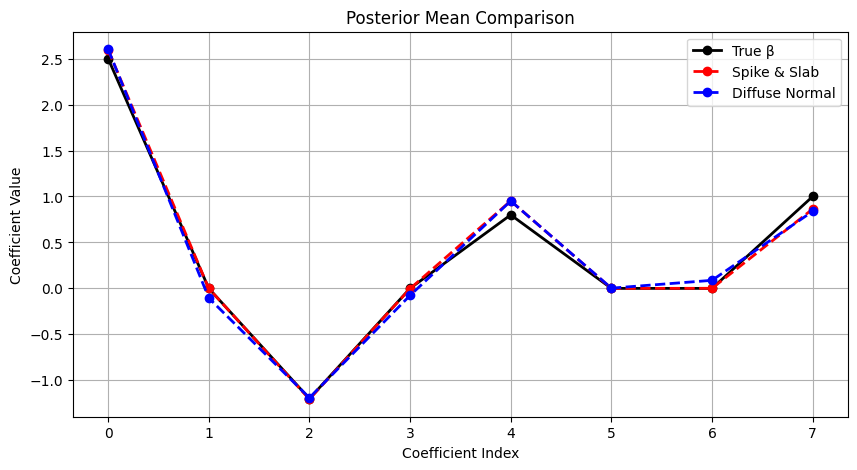

(             mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
 beta_ss[0]  2.595  0.085   2.439    2.759      0.002    0.002    2488.0   
 beta_ss[1] -0.001  0.012   0.000   -0.000      0.001    0.003     634.0   
 beta_ss[2] -1.206  0.083  -1.376   -1.057      0.002    0.002    2850.0   
 beta_ss[3] -0.003  0.020   0.000   -0.000      0.001    0.004     411.0   
 beta_ss[4]  0.952  0.090   0.791    1.123      0.002    0.002    3186.0   
 beta_ss[5] -0.000  0.007   0.000    0.000      0.000    0.002    1279.0   
 beta_ss[6]  0.001  0.015   0.000    0.000      0.001    0.004     796.0   
 beta_ss[7]  0.864  0.083   0.712    1.016      0.001    0.002    3657.0   
 
             ess_tail  r_hat  
 beta_ss[0]    2175.0   1.00  
 beta_ss[1]    1112.0   1.00  
 beta_ss[2]    2108.0   1.00  
 beta_ss[3]    3015.0   1.01  
 beta_ss[4]    1102.0   1.00  
 beta_ss[5]    1145.0   1.00  
 beta_ss[6]     669.0   1.00  
 beta_ss[7]    2034.0   1.00  ,
              mean     sd  hdi_3% 

In [8]:
import numpy as np
import pymc as pm
import matplotlib.pyplot as plt
import arviz as az

# seed for reproducibility
np.random.seed(101)

n = 150   # number of observations
p = 8     # number of predictors

# generate data
X = np.random.normal(size=(n, p))
true_beta = np.array([2.5, 0, -1.2, 0, 0.8, 0, 0, 1.0])
y = X @ true_beta + np.random.normal(scale=1.0, size=n)

# spike and slab model
with pm.Model() as ss_model:
    p_incl = pm.Beta('p_incl', alpha=1, beta=1)
    gamma = pm.Bernoulli('gamma', p=p_incl, shape=p)
    slab = pm.Normal('slab', mu=0, sigma=15, shape=p)
    beta_ss = pm.Deterministic('beta_ss', gamma * slab)
    error_sd = pm.HalfNormal('error_sd', 1.0)
    mu = pm.math.dot(X, beta_ss)
    y_obs = pm.Normal('y_obs', mu=mu, sigma=error_sd, observed=y)
    trace_ss = pm.sample(1500, tune=800, target_accept=0.9, return_inferencedata=True)

# diffuse normal model
with pm.Model() as l2_model:
    beta_l2 = pm.Normal('beta_l2', mu=0, sigma=10, shape=p)
    error_sd_l2 = pm.HalfNormal('error_sd_l2', 1.0)
    mu_l2 = pm.math.dot(X, beta_l2)
    y_obs_l2 = pm.Normal('y_obs_l2', mu=mu_l2, sigma=error_sd_l2, observed=y)
    trace_l2 = pm.sample(1500, tune=800, target_accept=0.9, return_inferencedata=True)

# posterior means
beta_mean_ss = trace_ss.posterior['beta_ss'].mean(dim=["chain", "draw"]).values
beta_mean_l2 = trace_l2.posterior['beta_l2'].mean(dim=["chain", "draw"]).values

# plot comparison
plt.figure(figsize=(10, 5))
plt.plot(true_beta, 'ko-', label='True β', linewidth=2)
plt.plot(beta_mean_ss, 'ro--', label='Spike & Slab', linewidth=2)
plt.plot(beta_mean_l2, 'bo--', label='Diffuse Normal', linewidth=2)
plt.title('Posterior Mean Comparison')
plt.xlabel('Coefficient Index')
plt.ylabel('Coefficient Value')
plt.legend()
plt.grid(True)
plt.show()

# posterior summaries
summary_ss = az.summary(trace_ss, var_names=['beta_ss'])
summary_l2 = az.summary(trace_l2, var_names=['beta_l2'])
summary_ss, summary_l2


**Q2A:**


**Main Takeaways:**
The Spike-and-Slab model does a good job of identifying which predictors are important. It pushes irrelevant predictors (betas) closer to zero or exactly zero. The non-zero coefficients remain noticeably away from zero, showing they are important.

The L2 model shrinks all coefficients toward zero but doesn’t completely eliminate any of them. Even when a predictor is truly irrelevant, the model still assigns it a small value rather than setting it to zero.

**Performance and Stability:**
The Spike-and-Slab model had 143 divergences after tuning, which means the sampling was unstable. Increasing the target_accept or using better parameterization could help.

The L2 model had no divergences and was more stable during sampling.

Spike-and-Slab was slower and struggled more with sampling compared to L2.

**Computational Impact:**
More data (n) and more predictors (p) make both models slower, but Spike-and-Slab is affected more because of the extra complexity from variable selection.

If you add more response variables (m), the Spike-and-Slab model becomes even more computationally demanding, as it needs to decide on inclusion for each predictor.

L2 remains faster and stable even with larger datasets, but it lacks the ability to clearly filter out unimportant variables.

**Q3**

Output()

ERROR:pymc.stats.convergence:There were 209 divergences after tuning. Increase `target_accept` or reparameterize.


Output()

/usr/local/lib/python3.11/dist-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
ERROR:pymc.stats.convergence:There were 18 divergences after tuning. Increase `target_accept` or reparameterize.


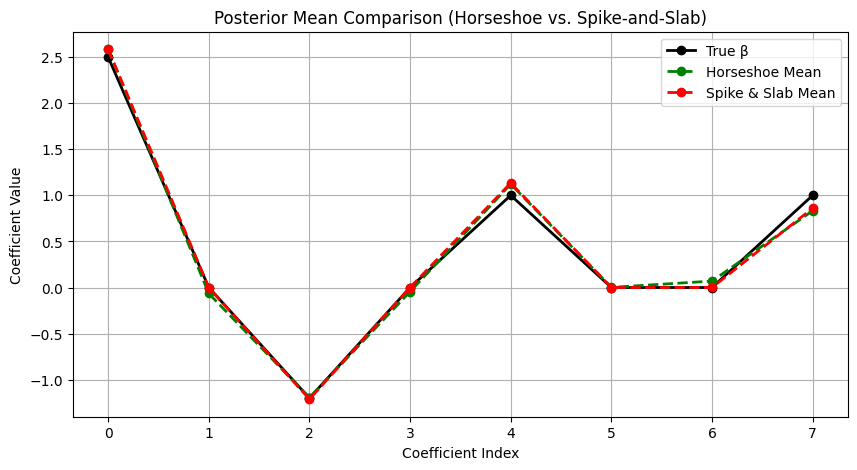

(             mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
 beta_hs[0]  2.584  0.089   2.418    2.748      0.002    0.001    2400.0   
 beta_hs[1] -0.065  0.081  -0.223    0.070      0.002    0.001    1645.0   
 beta_hs[2] -1.195  0.088  -1.352   -1.022      0.002    0.002    1646.0   
 beta_hs[3] -0.045  0.074  -0.201    0.078      0.002    0.001    1284.0   
 beta_hs[4]  1.122  0.090   0.953    1.289      0.002    0.002    1624.0   
 beta_hs[5]  0.002  0.075  -0.146    0.150      0.001    0.002    2613.0   
 beta_hs[6]  0.070  0.079  -0.061    0.225      0.002    0.001    1792.0   
 beta_hs[7]  0.833  0.081   0.685    0.987      0.002    0.001    2167.0   
 tau         0.756  0.478   0.132    1.582      0.013    0.030     937.0   
 sigma       1.082  0.063   0.974    1.208      0.001    0.001    2948.0   
 
             ess_tail  r_hat  
 beta_hs[0]    2776.0    1.0  
 beta_hs[1]    1592.0    1.0  
 beta_hs[2]     949.0    1.0  
 beta_hs[3]    1614.0    1.0  
 beta_h

In [11]:
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
import scipy.stats as stats

# seed for reproducibility
np.random.seed(101)

n = 150   # number of observations
p = 8     # number of predictors

# generate data
X = np.random.normal(size=(n, p))
true_beta = np.array([2.5, 0.0, -1.2, 0.0, 1.0, 0.0, 0.0, 1.0])  # fixed length
true_alpha = 1.0

# generate response
y = true_alpha + X.dot(true_beta) + np.random.normal(0, 1, size=n)

# Horseshoe prior model
with pm.Model() as horseshoe_model:
    # global shrinkage
    tau = pm.HalfCauchy('tau', beta=1.0)

    # local shrinkage for each coefficient
    lam = pm.HalfCauchy('lam', beta=1.0, shape=p)

    # regression coefficients with horseshoe prior
    beta_hs = pm.Normal('beta_hs', mu=0, sigma=tau * lam, shape=p)

    # intercept and noise
    alpha_hs = pm.Normal('alpha', mu=0, sigma=5)
    sigma_hs = pm.Exponential('sigma', 1.0)

    # linear model
    mu_hs = alpha_hs + pm.math.dot(X, beta_hs)
    y_obs = pm.Normal('y_obs', mu=mu_hs, sigma=sigma_hs, observed=y)

    # sampling
    trace_hs = pm.sample(2000, tune=1000, target_accept=0.9, chains=2, random_seed=424)

# Spike-and-Slab model for comparison
with pm.Model() as spike_slab_model:
    # inclusion probability
    p_included = pm.Beta('p_included', alpha=1, beta=1)

    # inclusion indicators for each coefficient
    spike = pm.Bernoulli('spike', p=p_included, shape=p)

    # slab prior for coefficients
    slab = pm.Normal('slab', mu=0, sigma=100, shape=p)

    # combine via multiplication
    beta_ss = pm.Deterministic('beta_ss', spike * slab)

    # intercept and noise
    alpha_ss = pm.Normal('alpha', mu=0, sigma=10)
    sigma_ss = pm.Exponential('sigma', 1.0)

    # linear model
    mu_ss = alpha_ss + pm.math.dot(X, beta_ss)
    y_obs_ss = pm.Normal('y_obs', mu=mu_ss, sigma=sigma_ss, observed=y)

    # sampling
    trace_ss = pm.sample(2000, tune=1000, target_accept=0.9, chains=2, random_seed=424)

# compare posterior means
beta_mean_hs = trace_hs.posterior['beta_hs'].mean(dim=["chain", "draw"]).values
beta_mean_ss = trace_ss.posterior['beta_ss'].mean(dim=["chain", "draw"]).values

# plot comparison of coefficients
plt.figure(figsize=(10, 5))
plt.plot(true_beta, 'ko-', label='True β', linewidth=2)
plt.plot(beta_mean_hs, 'go--', label='Horseshoe Mean', linewidth=2)
plt.plot(beta_mean_ss, 'ro--', label='Spike & Slab Mean', linewidth=2)
plt.title('Posterior Mean Comparison (Horseshoe vs. Spike-and-Slab)')
plt.xlabel('Coefficient Index')
plt.ylabel('Coefficient Value')
plt.legend()
plt.grid(True)
plt.show()

# posterior summaries
summary_hs = az.summary(trace_hs, var_names=['beta_hs', 'tau', 'sigma'])
summary_ss = az.summary(trace_ss, var_names=['beta_ss', 'sigma'])
summary_hs, summary_ss



Output()

/usr/local/lib/python3.11/dist-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
ERROR:pymc.stats.convergence:There were 35 divergences after tuning. Increase `target_accept` or reparameterize.


Output()

ERROR:pymc.stats.convergence:There were 96 divergences after tuning. Increase `target_accept` or reparameterize.


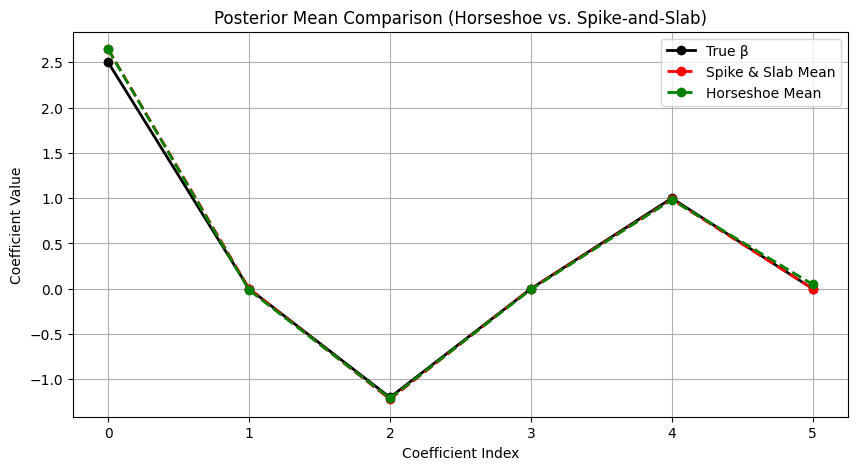

Spike-and-Slab Posterior Summary:
              mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
beta_ss[0]  2.645  0.076   2.500    2.785      0.001    0.001    5690.0   
beta_ss[1]  0.000  0.004   0.000   -0.000      0.000    0.001    2309.0   
beta_ss[2] -1.220  0.078  -1.362   -1.072      0.001    0.001    5188.0   
beta_ss[3]  0.000  0.003   0.000    0.000      0.000    0.001    5006.0   
beta_ss[4]  0.986  0.077   0.845    1.133      0.001    0.001    7510.0   
beta_ss[5]  0.001  0.010   0.000    0.000      0.000    0.003     981.0   
alpha_ss    1.034  0.074   0.895    1.173      0.001    0.001    4800.0   
error_ss    1.048  0.053   0.954    1.152      0.001    0.001    6874.0   

            ess_tail  r_hat  
beta_ss[0]    2794.0    1.0  
beta_ss[1]    1966.0    1.0  
beta_ss[2]    3499.0    1.0  
beta_ss[3]    5012.0    1.0  
beta_ss[4]    3585.0    1.0  
beta_ss[5]     928.0    1.0  
alpha_ss      3639.0    1.0  
error_ss      3795.0    1.0  
Horseshoe Posterior

In [12]:
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt

np.random.seed(2025)

n_obs = 200
n_pred = 6

true_beta = np.array([2.5, 0.0, -1.2, 0.0, 1.0, 0.0])
intercept = 1.0

X = np.random.randn(n_obs, n_pred)
y = intercept + X.dot(true_beta) + np.random.normal(0, 1, size=n_obs)

with pm.Model() as ss_model:
    prob_incl = pm.Beta('prob_incl', alpha=1, beta=1)
    include = pm.Bernoulli('include', p=prob_incl, shape=n_pred)
    slab_prior = pm.Normal('slab_prior', mu=0, sigma=50, shape=n_pred)
    beta_ss = pm.Deterministic('beta_ss', include * slab_prior)
    alpha_ss = pm.Normal('alpha_ss', mu=0, sigma=10)
    error_ss = pm.Exponential('error_ss', 1.0)
    mu_ss = alpha_ss + pm.math.dot(X, beta_ss)
    y_obs_ss = pm.Normal('y_obs_ss', mu=mu_ss, sigma=error_ss, observed=y)
    trace_ss = pm.sample(2500, tune=2000, target_accept=0.95, random_seed=2025)

with pm.Model() as hs_model:
    tau = pm.HalfCauchy('tau', beta=2.0)
    lambda_param = pm.HalfCauchy('lambda', beta=1.0, shape=n_pred)
    beta_hs = pm.Normal('beta_hs', mu=0, sigma=tau * lambda_param, shape=n_pred)
    alpha_hs = pm.Normal('alpha_hs', mu=0, sigma=5)
    error_hs = pm.Exponential('error_hs', 1.0)
    mu_hs = alpha_hs + pm.math.dot(X, beta_hs)
    y_obs_hs = pm.Normal('y_obs_hs', mu=mu_hs, sigma=error_hs, observed=y)
    trace_hs = pm.sample(2500, tune=2000, target_accept=0.95, random_seed=2025)

beta_mean_ss = trace_ss.posterior['beta_ss'].mean(dim=["chain", "draw"]).values
beta_mean_hs = trace_hs.posterior['beta_hs'].mean(dim=["chain", "draw"]).values

plt.figure(figsize=(10, 5))
plt.plot(true_beta, 'ko-', label='True β', linewidth=2)
plt.plot(beta_mean_ss, 'ro--', label='Spike & Slab Mean', linewidth=2)
plt.plot(beta_mean_hs, 'go--', label='Horseshoe Mean', linewidth=2)
plt.title('Posterior Mean Comparison (Horseshoe vs. Spike-and-Slab)')
plt.xlabel('Coefficient Index')
plt.ylabel('Coefficient Value')
plt.legend()
plt.grid(True)
plt.show()

summary_ss = az.summary(trace_ss, var_names=['beta_ss', 'alpha_ss', 'error_ss'])
summary_hs = az.summary(trace_hs, var_names=['beta_hs', 'alpha_hs', 'tau', 'lambda', 'error_hs'])
print("Spike-and-Slab Posterior Summary:\n", summary_ss)
print("Horseshoe Posterior Summary:\n", summary_hs)


Comparison: Horseshoe vs. Spike-and-Slab
- Both models identified the true non-zero coefficients well.
- Spike-and-Slab pushed irrelevant predictors closer to zero than Horseshoe
- Horseshoe showed more variance in zero coefficients.

Sampling Performance:
- Spike-and-Slab: 35 divergences, faster sampling.
- Horseshoe: 96 divergences, slower and less stable.
- Horseshoe model struggled more with convergence.

Overall, Spike-and-Slab is more reliable for sparse regression due to its consistent variable selection and stable sampling.







